In [1]:
# create virtual server here in notebook with access to all functions and variables
from IR_tools import *

In [7]:
# search settings

# # pre-NBhū
# priority_texts = [
#                     "VS", "MīmS", "MMK", "ViVy", "NS", "YSBh", "SK", 
#                     "ViṃśV", "NBh", "MīmBh", "ĀP", "PSV", "NPS", "TriṃśBh", 
#                     "YD", "PDhS", "NV", "PPad", "ŚV", "PVSV", "PV", "PVin", 
#                     "HB", "NB", "VN", "SAS", "SP", "BhāV", "BrS", "VibhrV", 
#                     "VidhV", "PSṬ", "HBṬ", "NBṬ", "PVA", "VSṬ", "TUS"
#                  ]

# # # others
# non_priority_texts = [
#                     "VyV", "NM", "NyKal", "NBhū", "SŚP", "ŚVK", "HBṬĀ", 
#                     "NyKand", "AvNir", "PVV", "TCM", "MukV"
#                     ]

# NBhū
priority_texts = [
                    "NBhū"
                 ]

# # others
non_priority_texts = [
                    "VS", "MīmS", "MMK", "ViVy", "NS", "YSBh", "SK", 
                    "ViṃśV", "NBh", "MīmBh", "ĀP", "PSV", "NPS", "TriṃśBh", 
                    "YD", "PDhS", "NV", "PPad", "ŚV", "PVSV", "PV", "PVin", 
                    "HB", "NB", "VN", "SAS", "SP", "BhāV", "BrS", "VibhrV", 
                    "VidhV", "PSṬ", "HBṬ", "NBṬ", "PVA", "VSṬ", "TUS",
                    "VyV", "NM", "NyKal", "SŚP", "ŚVK", "HBṬĀ", 
                    "NyKand", "AvNir", "PVV", "TCM", "MukV"
                    ]

N_tf_idf_shallow = int( len(doc_ids) * 0.15)
N_sw_w_shallow = 200

N_tf_idf_deep = int( len(doc_ids) * 1.00)
N_sw_w_deep = int( len(doc_ids) * 1.00)

In [8]:
# functions for assessing speed and summarizing results 

from datetime import datetime, date
from time import sleep

def calc_dur(start, end):
    delta = datetime.combine(date.today(), end) - datetime.combine(date.today(), start)
    duration_secs = delta.seconds + delta.microseconds / 1000000
    return duration_secs

def summarize_result(results, label, duration, num_comparisons, display_depth):
    print('{} ({:.3f} s, {} comparisons, {:.6f} s/comparison)'.format(
            label,
            duration, 
            num_comparisons,
            duration/num_comparisons
            )
    )
    for k,v in list(results.items())[:display_depth]:
        print(k, ": ", v)
    print()
    sleep(0.01)


In [9]:
# streamlined version of get_closest_docs() with no HTML rendering
# two modes: 1) speed_summary gives speed stats for single query; 2) return_values returns full dicts

def get_closest_docs_2(query_id, search_depth='shallow', prioritze=True, display_depth=10, mode='speed_summary'):
    
    if search_depth=='shallow':
        N_tf_idf = N_tf_idf_shallow
        N_sw_w = N_sw_w_shallow
    elif search_depth=='deep':
        N_tf_idf = N_tf_idf_deep
        N_sw_w = N_sw_w_deep
    
    # rank candidates by topic similarity

    start1 = datetime.now().time()
    all_topic_candidates = rank_all_candidates_by_topic_similarity(
        query_id
        )    
    end1 = datetime.now().time()
    topic_time = calc_dur(start1, end1)
    if mode=='speed_summary': summarize_result(
        results=all_topic_candidates,
        label='topics',
        duration=topic_time,
        num_comparisons=len(doc_ids),
        display_depth=display_depth
    )

    if prioritze:
        # prioritize candidates by text name, discard secondary candidates
            priority_candidate_ids, _ = divide_doc_id_list_by_work_priority(
                list(all_topic_candidates.keys()),
                priority_texts
                )
            priority_topic_candidates = { doc_id: all_topic_candidates[doc_id]
                for doc_id in priority_candidate_ids
                }
    else:
        # don't prioritize
        priority_topic_candidates = all_topic_candidates
        priority_topic_candidate_ids = list(all_topic_candidates.keys())
    
    # limit further computation to only top N_tf_idf of sorted candidates (minus query itself)
    pruned_priority_topic_candidates = { k:v
        for (k,v) in list(priority_topic_candidates.items())[:N_tf_idf-1]
        }

    # further rank candidates by tiny tf-idf
    start2 = datetime.now().time()
    tf_idf_candidates = rank_candidates_by_tiny_TF_IDF_similarity(
        query_id,
        list(pruned_priority_topic_candidates.keys())
        )
    end2 = datetime.now().time()
    tf_idf_time = calc_dur(start2, end2)
    if mode=='speed_summary': summarize_result(
        results=tf_idf_candidates,
        label='tf-idf',
        duration=tf_idf_time,
        num_comparisons=N_tf_idf,
        display_depth=display_depth
    )

    # limit further computation to only top N_sw_w of sorted candidates
    pruned_tf_idf_candidates = { k:v
        for (k,v) in list(tf_idf_candidates.items())[:N_sw_w-1]
        }

    # further rank candidates by sw_w
    start3 = datetime.now().time()
    sw_w_candidates = rank_candidates_by_sw_w_alignment_score(
        query_id,
        list(pruned_tf_idf_candidates.keys())
        )
    end3 = datetime.now().time()
    sw_w_time = calc_dur(start3, end3)

    # do not convert sw_w scores of 0.0 to empty string
    
    # create overall results ordered in terms of sw_w, then tf_idf, then priority topics
    overall_results = {}

    for k in sw_w_candidates.keys():
        overall_results[k] = {'sw_w': sw_w_candidates[k], 'tf_idf': tf_idf_candidates[k], 'priority_topic': priority_topic_candidates[k]}
    for k in tf_idf_candidates.keys():
        if k not in overall_results:
            overall_results[k] = {'sw_w': 0, 'tf_idf': tf_idf_candidates[k], 'priority_topic': priority_topic_candidates[k]}
    for k in priority_topic_candidates.keys():
        if k not in overall_results:
            overall_results[k] = {'sw_w': 0, 'tf_idf': 0, 'priority_topic': priority_topic_candidates[k]}
    
    if mode=='speed_summary':
        summarize_result(
            results=sw_w_candidates, 
            label='sw_w', 
            duration=sw_w_time, 
            num_comparisons=N_sw_w, 
            display_depth=display_depth
        )
        return

    elif mode=='return_values':
        return all_topic_candidates, priority_topic_candidates, tf_idf_candidates, sw_w_candidates, overall_results


In [10]:
# test single 'speed_summary' run, shallow (no values returned)

get_closest_docs_2('NBhū_142,19', search_depth='shallow', display_depth=10, mode='speed_summary')

topics (0.978 s, 28381 comparisons, 0.000034 s/comparison)
PVA_629,vi :  0.9698818351650111
PVSV_010,13_010,15 :  0.9523222396152328
NBṬ_217,iii_217,v :  0.9382695193578188
PVSV_010,19_010,21 :  0.9165924117385076
PVin_II,045,iii :  0.913539875583041
PVA_612,i_612,iii :  0.9116307949243329
PVV_290,iv_290,v :  0.895139987240839
PVV_493,viii_493,x :  0.8912334689992081
PVin_I,091,i_I,092,i :  0.8910857329884588
PVin_II,123,i_II,123,ii :  0.8907492314066945

tf-idf (0.734 s, 4257 comparisons, 0.000172 s/comparison)
NBhū_190,16 :  0.12741331434898207
NBhū_349,4 :  0.09907481164467283
NBhū_191,20_191,24 :  0.09530049559200143
NBhū_449,23^3 :  0.08698010177181863
NBhū_230,10 :  0.08513162516688205
NBhū_150,6^2 :  0.07816790972776852
NBhū_309,17 :  0.07664541424192375
NBhū_147,16 :  0.07622049377798693
NBhū_148,4_148,7^1 :  0.07564425314613296
NBhū_139,26_140,1 :  0.07368097485995155

sw_w (1.130 s, 200 comparisons, 0.005651 s/comparison)
NBhū_519,6^2 :  23.0
NBhū_59,11^1 :  23.0
NBhū_303,18 

In [6]:
# run for 'speed_summary', deep (no values returned)

# get_closest_docs_2('NBhū_142,19', search_depth='deep', display_depth=10, mode='speed_summary')

In [16]:
# identify my NBhū docs

NBhu_doc_ids = [ di for di in doc_ids if parse_complex_doc_id(di)[0] == 'NBhū' ]
print(len(NBhu_doc_ids), "overall,", NBhu_doc_ids[238], "–", NBhu_doc_ids[377], '=', 377-238+1)

doc_id_full_list = NBhu_doc_ids[238:377+1]
print(len(doc_id_full_list))

# or do this for all NBhū docs

# doc_id_full_list = NBhu_doc_ids
# print(doc_id_full_list[0], doc_id_full_list[-1])

1765 overall, NBhū_104,6^1 – NBhū_154,15 = 140
140


In [8]:
# or take Yuki's PVV docs

# doc_ids.index("PVV_154,i_154,iii")
# doc_ids.index("PVV_176,vi_176,vii")
doc_id_full_list = doc_ids[14265:14340+1]

# 14265 = "PVV_154,i_154,iii"
# 14340 = "PVV_176,vi_176,vii"
len(doc_id_full_list)

76

In [11]:
# generalized way to choose series of docs within a given work
# in interface, there will be one first work drop-down, then two drop-downs for individual doc_ids
# do not enforce same text here
# do enforce relative ordering here

def choose_series(doc_id_1, doc_id_2):

    doc_id_1_index = doc_ids.index(doc_id_1)
    doc_id_2_index = doc_ids.index(doc_id_2)

    # check that doc_id_2 after doc_id_1
    if not doc_id_2_index > doc_id_1_index:
        print("doc_id_2 not after doc_id_1")
        return [doc_id_1] # can always do the first one at least

    else:
        doc_id_series = [ doc_ids[i] for i in range(doc_id_1_index, doc_id_2_index+1) ]
        return doc_id_series

In [12]:
# test for my NBhū docs

doc_id_1 = "NBhū_104,6^1"
doc_id_2 = "NBhū_154,15"
doc_id_series = choose_series(doc_id_1, doc_id_2)
print(len(doc_id_series))


140


In [14]:
# or all NBhū

doc_id_series = choose_series('NBhū_1,7_2,2', 'NBhū_598,17_598,19')
print(len(doc_id_series))




1765


In [12]:
# or for PVV

doc_id_series = choose_series('PVV_154,i_154,iii', 'PVV_176,vi_176,vii')
print(len(doc_id_series))


76


In [13]:
# or for PVA selection
doc_id_series = choose_series('PVA_353,ii_353,iv', 'PVA_365,ii')

In [8]:
# set up doc pairs to evaluate as expected from benchmark

doc_id_suspected_pair_list = [
('NBhū_104,6^1', 'PVin_I,034,i'),
('NBhū_104,6^2', 'PV_3.148ab_3.150cd'),
('NBhū_104,6^2', 'NS_4.2.1_4.2.7'),
('NBhū_104,6^2', 'NS_4.2.8_4.2.14'),
('NBhū_106,3', 'NS_4.2.23_4.2.28'),
('NBhū_106,3', 'NV_487,02_487,04'),
('NBhū_106,11_107,1', 'ViṃśV_93,i_95,i'),
('NBhū_106,11_107,1', 'PVin_I,035,i_I,036,ii'),
('NBhū_106,11_107,1', 'NS_4.2.15_4.2.22'),
('NBhū_107,6_108,1', 'PVin_I,039,i_I,039,ii'),
('NBhū_108,4_108,6', 'PVin_I,040,i'),
('NBhū_108,10', 'PVin_I,041,i'),
('NBhū_108,10', 'PV_3.431cd_3.434cd'),
('NBhū_109,1', 'PV_3.431cd_3.434cd'),
('NBhū_109,7', 'PV_3.329ab_3.332ab'),
('NBhū_109,7', 'PVin_I,035,i_I,036,ii'),
('NBhū_115,1_115,4', 'PV_3.281ab_3.284ab'),
('NBhū_115,18', 'PVA_289,xiv_290,ii'),
('NBhū_115,18', 'PVA_289,xiv_290,ii'),
('NBhū_115,18', 'PVA_290,iii'),
('NBhū_115,18', 'PVA_290,iv_290,vi'),
('NBhū_116,7', 'NS_4.1.35_4.1.42'),
('NBhū_116,7', 'NV_454,17_454,18'),
('NBhū_117,3^1', 'PVA_288,vii'),
('NBhū_117,3^2', 'PVA_288,vii'),
('NBhū_117,3^2', 'PV_3.208cd_3.211ab'),
('NBhū_121,2^2', 'PVin_I,046,i_I,046,iii'),
('NBhū_124,8^2', 'PV_2.066ab_2.069ab'),
('NBhū_125,15', 'ŚV_5,4.250ab_5,4.253ab'),
('NBhū_126,6^1', 'NS_4.2.8_4.2.14'),
('NBhū_126,6^1', 'NBh_1047,i_1047,ii'),
('NBhū_126,6^1', 'NS_2.1.33_2.1.39'),
('NBhū_126,6^3', 'NS_2.1.33_2.1.39'),
('NBhū_126,6^3', 'NS_4.2.8_4.2.14'),
('NBhū_131,11_131,17', 'ViṃśV_93,i_95,i'),
('NBhū_132,2', 'NS_4.2.15_4.2.22'),
('NBhū_132,11^1', 'TUS_ii,102,i_ii,102,ii'),
('NBhū_132,11^1', 'PV_3.386cd_3.389cd'),
('NBhū_138,9', 'PVA_353,x'),
('NBhū_138,9', 'PVA_353,xi_353,xii'),
('NBhū_139,1_139,3', 'PVA_353,xiii_353,xv'),
('NBhū_139,1_139,3', 'PVSV_022,06_022,20'),
('NBhū_139,1_139,3', 'PVin_I,086,ii^1'),
('NBhū_139,26_140,1', 'PV_3.326ab_3.328cd'),
('NBhū_140,21', 'PVin_I,046,i_I,046,iii'),
('NBhū_142,2', 'PV_3.329ab_3.332ab'),
('NBhū_142,12', 'PVA_387,xvii_387,xxii'),
('NBhū_142,12', 'PVA_359,iv_359,vi'),
('NBhū_142,19', 'PVA_361,xiii_361,xvi'),
('NBhū_142,19', 'PVSV_010,13_010,15'),
('NBhū_142,19', 'PVSV_010,19_010,21'),
('NBhū_142,19', 'PVin_I,091,i_I,092,i'),
('NBhū_142,19', 'PVin_I,092,ii_I,092,iii'),
('NBhū_144,20^1', 'PVA_361,xiii_361,xvi'),
('NBhū_145,15', 'PVA_360,ix'),
('NBhū_145,15', 'PVA_360,x'),
('NBhū_145,22', 'PVA_360,x'),
('NBhū_145,22', 'PVA_360,xi_361,i'),
('NBhū_146,7', 'PVA_360,xi_361,i'),
('NBhū_146,7', 'PVA_361,ii_361,iii'),
('NBhū_146,14_146,18', 'PVA_361,ii_361,iii'),
('NBhū_146,14_146,18', 'PVA_361,iv_361,vi'),
('NBhū_146,21', 'PVA_361,iv_361,vi'),
('NBhū_146,21', 'PVA_361,vii'),
('NBhū_147,3_147,6', 'PVA_361,x_361,xii'),
('NBhū_149,4_149,16', 'PVA_366,v_366,ix'),
('NBhū_149,19', 'PVA_366,iv'),
('NBhū_150,1', 'HB_3,1^1'),
('NBhū_150,1', 'PV_2.001ab_2.005cd'),
('NBhū_150,6^2', 'PVin_II,001,i_II,001,ii'),
('NBhū_150,6^2', 'NB_3.1_3.8'),
('NBhū_153,4_153,7', 'PVA_356,iv_356,vii'),
('NBhū_153,14', 'PVA_358,ix^4')
]

num_expected_pairs = len(doc_id_suspected_pair_list)

# turn into dict of lists
doc_id_suspected_pair_dict = {}
for doc_id_1, doc_id_2 in doc_id_suspected_pair_list:
    if doc_id_1 not in doc_id_suspected_pair_dict:
        doc_id_suspected_pair_dict[doc_id_1] = [doc_id_2]
    else:
        doc_id_suspected_pair_dict[doc_id_1].append(doc_id_2)

In [13]:
# function for describing doc_id's position in ranked results as well as giving absolute score

def format_score_summary(ranking_dict, doc_id):

    if doc_id in ranking_dict:

        ks = list(ranking_dict.keys())
        rank = ks.index(doc_id) + 1
        score = ranking_dict[doc_id]

        return "{} ({:.2f})".format(rank, score)

    else:
        return ""

In [14]:
from tqdm.notebook import tqdm

In [17]:
# compare performance against benchmark
# i.e., loop over get_closest_docs_2() in mode='return_values'
# outputs to tsv spreadsheet

pbar = tqdm(total=len(doc_id_full_list))

output_buffer_1 = ""
output_buffer_2 = '\t'.join([
    "doc_id", "num_expected_pairs", "num_pairs_confirmed",
    "num_novel_pairs[50]", "num_novel_pairs[40]", "num_novel_pairs[30]"
    ]) + '\n'
i = 0
rank_threshold = 5 # this determines whether system "CONFIRMS" an expected pair
sw_w_min_threshold = 50 # this determines a "NOVEL PAIR" (but cp. num_novel_pairs below)
sw_w_threshold_for_display = 50 # for use with num_novel_pairs below
for doc_id_1 in doc_id_full_list:

    # announce new doc_id_1
    
    print()
    print(doc_id_1)
    something_to_say = False # in case totally uneventful, will output "(none)"

    # perform full search of doc_id_1 with get_closest_docs_2() in 'return_values' mode
    # mode name a bit obsolete, most important is that 

    all_topic_candidates, priority_topic_candidates, tf_idf_candidates, sw_w_candidates, overall_results = get_closest_docs_2(
        doc_id_1, search_depth='shallow', mode='return_values'
    )

    # get doc_id_2 pair suspects

    if doc_id_1 in doc_id_suspected_pair_dict:
        doc_id_2_list = doc_id_suspected_pair_dict[doc_id_1]
        num_pairs_confirmed = 0
    else:
        doc_id_2_list = []
        num_pairs_confirmed = ""
        
    # evaluate each supposed pair
    
    num_expected_pairs = len(doc_id_2_list)
    for doc_id_2 in doc_id_2_list:
        
        something_to_say = True

        # format four ranked scores as "rank (score)"
        topic_all_scores = format_score_summary(all_topic_candidates, doc_id_2)
        topic_priority_scores = format_score_summary(priority_topic_candidates, doc_id_2)
        tf_idf_scores = format_score_summary(tf_idf_candidates, doc_id_2)
        sw_w_scores = format_score_summary(sw_w_candidates, doc_id_2)

        # format results for output to spreadsheet
        output_buffer_1 += '\t'.join([
            str(i),
            doc_id_1,
            doc_id_2,
            topic_all_scores,
            topic_priority_scores,
            tf_idf_scores,
            sw_w_scores,
        ]) + '\n'
        
        # have msg ready to confirm in notebook significant scores for suspected pairs
        if sw_w_scores == "":
            rank = 0
            sw_w_abs_score = 0
        else:
            rank_str, sw_w_abs_score_str = sw_w_scores.split(' ', 1)
            rank = int(rank_str)
            sw_w_abs_score = float(sw_w_abs_score_str[1:-1])
                
        confirmation_msg = (0 < rank <= rank_threshold) * '(CONFIRMED)'
        num_pairs_confirmed += bool(confirmation_msg) * 1

        # output to notebook
        i += 1
        print("pair #{}/{} ({}, {}): {} {} {} {} {}".format(
            i, num_expected_pairs,
            doc_id_1, doc_id_2,
            topic_all_scores,
            topic_priority_scores,
            tf_idf_scores,
            sw_w_scores,
            confirmation_msg
            )
        )

    # also report novel findings
        
    num_novel_pairs = {30: 0, 40: 0, 50: 0}
    for k,v in sw_w_candidates.items():

        if v > sw_w_min_threshold and k not in doc_id_2_list:
            
            something_to_say = True

            for threshold in num_novel_pairs.keys():
                if v > threshold:
                    num_novel_pairs[threshold] += 1

            # format four ranked scores as "rank (score)"
            topic_all_scores = format_score_summary(all_topic_candidates, k)
            topic_priority_scores = format_score_summary(priority_topic_candidates, k)
            tf_idf_scores = format_score_summary(tf_idf_candidates, k)
            sw_w_scores = format_score_summary(sw_w_candidates, k)

            # format results for output to spreadsheet
            output_buffer_1 += '\t'.join([
                "no id",
                doc_id_1,
                k,
                topic_all_scores,
                topic_priority_scores,
                tf_idf_scores,
                sw_w_scores,
            ]) + '\n'

            # output to notebook
            print("NOVEL PAIR ({}, {}): {} {} {} {}".format(
                doc_id_1, k,
                topic_all_scores,
                topic_priority_scores,
                tf_idf_scores,
                sw_w_scores,
                )
            )
        
        # stop once scores too low
        elif (v < sw_w_min_threshold):
            break
    
    if num_expected_pairs > 0:
        print("expected pairs confirmed (@{}): {}/{}".format(rank_threshold, num_pairs_confirmed, num_expected_pairs))
    if num_novel_pairs[sw_w_threshold_for_display] > 0:
        print("novel pairs (@{}): {}".format(sw_w_min_threshold, num_novel_pairs[sw_w_threshold_for_display]))
        
    # give explicit negative output in notebook if there are neither suspected pairs nor novel findings
    if not something_to_say:
        print("(none)")

    # prepare final summary of doc_1 output to second file
    output_buffer_2 += "{}\t{}\t{}\t{}\t{}\t{}".format(
        doc_id_1, num_expected_pairs, num_pairs_confirmed,
        num_novel_pairs[50], num_novel_pairs[40], num_novel_pairs[30]
        ) + '\n'
        
    # update progress bar as last thing
    pbar.update()        

            
# finish up

with open('pairs.tsv','w') as f_out_1:
    f_out_1.write(output_buffer_1)

with open('doc_1_summaries.tsv','w') as f_out_2:
    f_out_2.write(output_buffer_2)
    
pbar.close()


NBhū_104,6^1


NameError: name 'doc_id_suspected_pair_dict' is not defined

In [15]:
# define complex threshold condition
# can specify 1–3 options ("1","2","3" below) ("OR")
# within each option, can specify lower bounds for 1–3 measures ('sw_w', 'tf_idf', 'priority_topic') ("AND")
# cannot yet specify upper bounds

threshold_inputs = {
    1: {
        'sw_w':"50",
        'tf_idf':"",
        'priority_topic':""
        },
    2: {
        'sw_w':"",
        'tf_idf':"",
        'priority_topic':""
        },
    3: {
        'sw_w':"",
        'tf_idf':"",
        'priority_topic':""
        },
}

conditions = {} # int to string

for i in range(1,4):

    # create individual "AND" expression

    conditions[i] = ""

    for measure in ['sw_w', 'tf_idf', 'priority_topic']:
        if threshold_inputs[i][measure] == "":
            pass
        else:
            if conditions[i] != "":
                conditions[i] += " & "
            conditions[i] += "(overall_results[k]['{}'] >= {})".format(
                measure, 
                threshold_inputs[i][measure]
            )

    if conditions[i] == "":
        conditions[i] = "False" # empty condition just contributes False to OR

# create overall "OR" expression
overall_condition = "{} | {} | {}".format(conditions[1], conditions[2], conditions[3])

print(overall_condition)

(overall_results[k]['sw_w'] >= 50) | False | False


In [18]:
import time

T_topic  = 0.000007
T_tf_idf = 0.000315
T_sw_w   = 0.004513
query_time_estimate = T_topic * len(doc_ids) + T_tf_idf * N_tf_idf_shallow + T_sw_w * N_sw_w_shallow
total_time_estimate = query_time_estimate * len(doc_id_series)
print(time.strftime('%H:%M:%S', time.gmtime(total_time_estimate)))

01:11:50


In [19]:
"""
need to streamline above presentations into one main output format
    HTML table to PDF seems like good default

it will NOT include any of the "confirm" functionality assuming "expected pairs"

rather, it will be based on one or more thresholds
    sw_w is clear and simplest, 30–50 are reasonable values
    but could also set thresholds for tf_idf and topic (both [0,1])
    threshold comparisons can be combined either as "AND" (i.e., all required) or as "OR" (i.e., any suffices)
    actually most desirable is a series of nested conditions
        e.g. (sw_w > 50) OR (sw_w > 30 AND tf_idf > 0.8) OR (topic > 0.9 AND tf_idf > 0.5)
"""

import urllib.parse

pbar = tqdm(total=len(doc_id_series))

# title
HTML_buffer = """
<h1 align="center">Search Results for {}</h1>""".format(
    '{} – {}'.format(doc_id_series[0], doc_id_series[-1])
    )

# start table with header row
HTML_buffer += """
<table border="1px solid #dddddd;" width="100%">
  <thead>
    <tr align="center">
      <th width="10%">{}</th>
      <th width="10%">{}</th>
      <th width="5%">{}</th>
      <th width="5%">{}</th>
      <th width="5%">{}</th>
      <th width="5%">{}</th>
      <th width="25%">{}</th>
      <th width="5%">{}</th>
    </tr>
  </thead>
  <tbody>
""".format( 'doc_id_1',
            'doc_id_2',
            'topic (all)',
            'topic (priority)',
            'tf-idf',
            'sw',
            'text of best match (doc 1)',
            'dcCp url'
            )

# added and subtracted throughout search for continuously refreshable results
HTML_buffer_suffix = """
  </tbody>
</table>
"""

for i, doc_id_1 in enumerate(doc_id_series):

    # perform full search of doc_id_1 with get_closest_docs_2() in 'return_values' mode
    all_topic_candidates, priority_topic_candidates, tf_idf_candidates, sw_w_candidates, overall_results = get_closest_docs_2(
        doc_id_1, search_depth='shallow', mode='return_values'
    )
    
    for k in overall_results.keys():

        if eval(overall_condition):

            # format four ranked scores as "rank (score)"
            topic_all_scores = format_score_summary(all_topic_candidates, k)
            topic_priority_scores = format_score_summary(priority_topic_candidates, k)
            tf_idf_scores = format_score_summary(tf_idf_candidates, k)
            sw_w_scores = format_score_summary(sw_w_candidates, k)

            # do alignment again, not super efficient but ok for now, to avoid complicating rank_by_sw
            text_1 = doc_fulltext[doc_id_1]
            text_2 = doc_fulltext[k]
            subseq1_pos, subseq2_pos, subseq1_len, subseq2_len, score = sw_align(text_1, text_2, words=False)
            subseq_in_text_1 = text_1[subseq1_pos:subseq1_pos+subseq1_len]

            url = "https://www.vatayana.info/docCompare?doc_id_1={}&doc_id_2={}".format(
                urllib.parse.quote(doc_id_1), urllib.parse.quote(k)
                )
            link = "<a href='{}' target='vatayana'>dcCp ↪</a>".format(url)

            # format results for output
            HTML_buffer += """
                <tr align="center">
                  <td>{}</td>
                  <td>{}</td>
                  <td>{}</td>
                  <td>{}</td>
                  <td>{}</td>
                  <td>{}</td>
                  <td align="left">{}</td>
                  <td>{}</td>
                </tr>
            """.format(
                doc_id_1,
                k,
                topic_all_scores,
                topic_priority_scores,
                tf_idf_scores,
                sw_w_scores,
                subseq_in_text_1,
                link
                )
    
    HTML_buffer += HTML_buffer_suffix
    
    time_left = total_time_estimate * (len(doc_id_series)-i-1)/len(doc_id_series)
    fudge_factor = 2 # old estimates are off! need to better understand and improve
    time_left *= fudge_factor 
    progress_update = "<h2 align='center'>In progress... {}/{} complete, approximately {} remaining</h2>".format(
        i+1, 
        len(doc_id_series),
        time.strftime('%H:%M:%S', time.gmtime(time_left))
    )
    HTML_buffer += progress_update
    
    with open('similarity_results.html','w') as f_out:
        f_out.write(HTML_buffer)
    
    HTML_buffer = HTML_buffer[:-len(progress_update)] # i.e., HTML_buffer -= progress_update
    HTML_buffer = HTML_buffer[:-len(HTML_buffer_suffix)] # i.e., HTML_buffer -= HTML_buffer_suffix
    
    pbar.update()        

# finish up

HTML_buffer += HTML_buffer_suffix

progress_update = "<h2 align='center'>Completed {}/{} queries.</h2>".format(
        i+1,
        len(doc_id_series)
    )
HTML_buffer += progress_update
    
with open('similarity_results.html','w') as f_out:
    f_out.write(HTML_buffer)

pbar.close()

In [109]:
# simple run to output full scores for covariance testing

pbar = tqdm(total=len(doc_id_full_list))
all_results = {}
for doc_id_1 in doc_id_full_list:

    # perform full search of doc_id_1 with get_closest_docs_2() in 'return_values' mode
    _, _, _, _, overall_results = get_closest_docs_2(doc_id_1, search_depth='deep', mode='return_values')
    all_results[doc_id_1] = overall_results

    # update progress bar as last thing
    pbar.update()        

            
# finish up

# with open('pairs.tsv','w') as f_out_1:
#     f_out_1.write(output_buffer_1)

# with open('doc_1_summaries.tsv','w') as f_out_2:
#     f_out_2.write(output_buffer_2)
    
pbar.close()

In [110]:
output_buffer = ""
output_buffer += "\t".join([
                            '',
#                             'doc_id_1 vs. doc_id_2',
                            'priority_topic',
                            'tf_idf',
                            'sw_w'
                            ]) + '\n'

for j, doc_id_1 in enumerate(doc_id_full_list):
    for i, doc_id_2 in enumerate(all_results[doc_id_1]):
        output_buffer += "\t".join([
                            f"{j+1}.{i+1}",
#                             f"{doc_id_1} vs. {doc_id_2}", 
                            str(all_results[doc_id_1][doc_id_2]['priority_topic']),
                            str(all_results[doc_id_1][doc_id_2]['tf_idf']),
                            str(all_results[doc_id_1][doc_id_2]['sw_w'])
                            ]) + '\n'

with open('full_scores_NBhū_104_154.tsv','w') as f_out:
    f_out.write(output_buffer)

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

%matplotlib inline


In [111]:
data = pd.read_csv('full_scores_NBhū_104_154.tsv', sep='\t', index_col=0)
print(len(data))
data.head()

246960


,priority_topic,tf_idf,sw_w
1.1,0.846372,0.236414,88.0
1.2,0.803246,0.267180,46.2
1.3,0.313328,0.063078,31.0
1.4,0.001545,0.062690,30.8
1.5,0.648602,0.085779,27.6


In [106]:
# list(data.items())

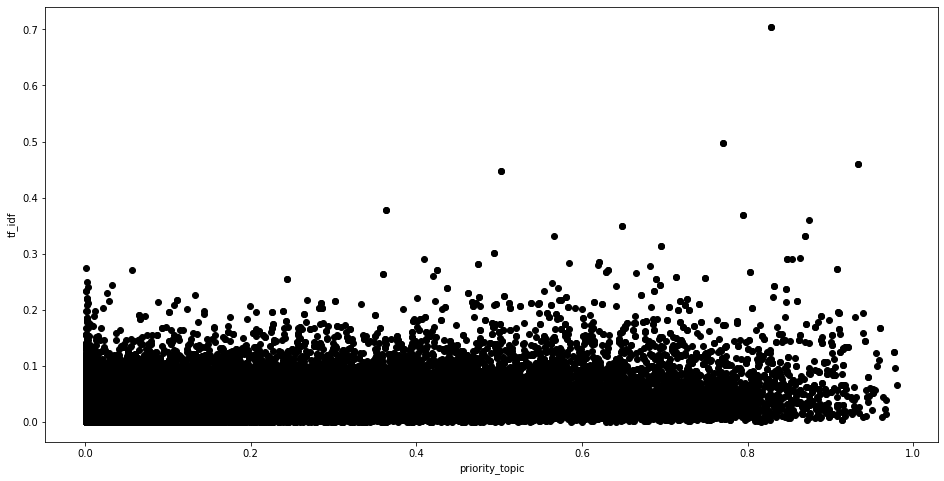

In [112]:
plt.figure(figsize=(16,8))
plt.scatter(data['priority_topic'], data['tf_idf'], c='black')
plt.xlabel('priority_topic')
plt.ylabel('tf_idf')
plt.show()

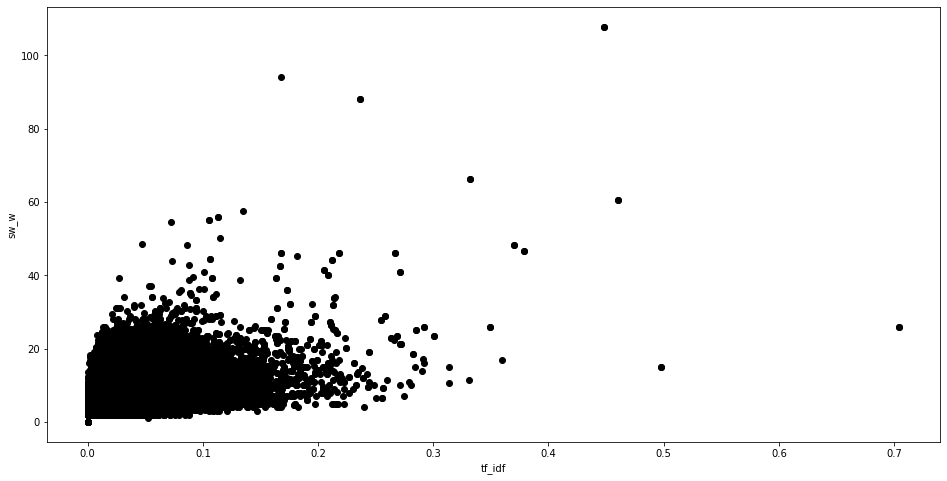

In [113]:
plt.figure(figsize=(16,8))
plt.scatter(data['tf_idf'], data['sw_w'], c='black')
plt.xlabel('tf_idf')
plt.ylabel('sw_w')
plt.show()

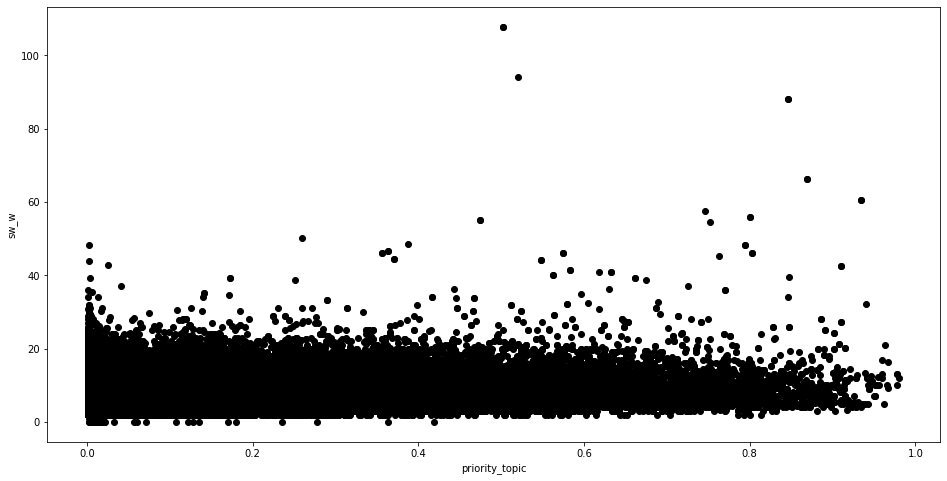

In [114]:
plt.figure(figsize=(16,8))
plt.scatter(data['priority_topic'], data['sw_w'], c='black')
plt.xlabel('priority_topic')
plt.ylabel('sw_w')
plt.show()